In [1]:
from qampy import signals, impairments, equalisation, phaserec, helpers
from qampy.theory import ber_vs_es_over_n0_qam as ber_theory
from qampy.helpers import normalise_and_center as normcenter
from qampy.core.filter import rrcos_pulseshaping as lowpassFilter
import matplotlib.pyplot as plt
import numpy as np
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from scipy.stats import kde
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

output_notebook()

Loading BokehJS ...

In [2]:
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['lines.linewidth'] = 2

In [3]:
def plot_constellation(E):

    npol = E.shape
    fig = figure(title="QAM snal constellation", output_backend="webgl")

    if npol[0] == 2:
        fig.scatter(E[0].real, E[0].imag, color='red',
                    alpha=0.3, legend_label="X")
        fig.scatter(E[1].real, E[1].imag, color='blue',
                    alpha=0.3, legend_label="Y")
    elif npol[0] == 1:
        fig.scatter(E[0].real, E[0].imag, color='red',
                    alpha=0.3, legend_label="X")

    fig.xaxis[0].axis_label = "In-Phase"
    fig.yaxis[0].axis_label = "Quadrature"
    show(fig)


def plot_constellation_fancy(E):
    npol = E.shape

    nbins = 100
    if npol[0] == 2:
        for indPlot in range(0, 2):
            x = E[indPlot].real
            y = E[indPlot].imag

            k = kde.gaussian_kde([x, y])
            xi, yi = np.mgrid[x.min():x.max():nbins*1j,
                              y.min():y.max():nbins*1j]
            zi = k(np.vstack([xi.flatten(), yi.flatten()]))

            # Make the plot
            plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
            plt.pcolormesh(xi, yi, zi.reshape(xi.shape),
                           shading='gouraud', cmap='Blues')
            plt.show()
    elif npol[0] == 1:
        x = E[0].real
        y = E[0].imag

        k = kde.gaussian_kde([x, y])
        xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))

        # Make the plot
        plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
        plt.pcolormesh(xi, yi, zi.reshape(xi.shape),
                       shading='gouraud', cmap='Blues')
        plt.show()

In [4]:
# Geração do sinal QAM

M = 64        # ordem da modulação
Fb = 40e9      # taxa de símbolos
SpS = 4         # amostras por símbolo
Fs = SpS*Fb    # taxa de amostragem
SNR = 40        # relação sinal ruído (dB)
rolloff = 0.01  # Rolloff do filtro formatador de pulso

# Gera sequência de símbolos QAM e a filtra com um filtro formatador de pulso rrc (root-raised cosine)
s = signals.ResampledQAM(M, 2**16, fb=Fb, fs=Fs, nmodes=2,
                         resamplekwargs={"beta": rolloff, "renormalise": True})

# Adiciona ruído gaussiano
s = impairments.simulate_transmission(s, snr=SNR)

# Detecção do sinal com filtro casado + downsampling e normalização do sinal para energia média 1
# (para visualização da constelação)

symb = normcenter(s.resample(fnew=Fb, beta=rolloff))

# Plota constelação
# plot_constellation(symb)
# plot_constellation_fancy(symb)

# Caclula parâmetros de desempenho
SNR_est = 10*np.log10(symb.est_snr())
GMI_est = symb.cal_gmi()

np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})
print("Parâmetros de desempenho:\n")
print("SNR estimada da constelação: ", np.array2string(SNR_est), " dB")
print("GMI estimada da constelação: ", np.array2string(
    GMI_est[0][0]), np.array2string(GMI_est[0][1]), " bits/symb")
print("BER: ", symb.cal_ber())
print("BER (teórica): ", np.array2string(ber_theory(helpers.dB2lin(SNR), M)))

Parâmetros de desempenho:

SNR estimada da constelação:  [39.979443 39.948186]  dB
GMI estimada da constelação:  6.000000 5.989982  bits/symb
BER:  [0.000000 0.000003]
BER (teórica):  0.000000


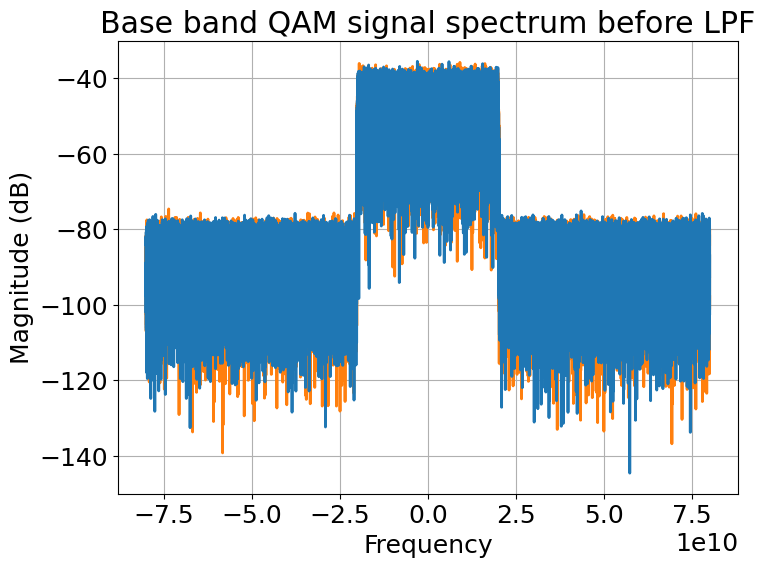

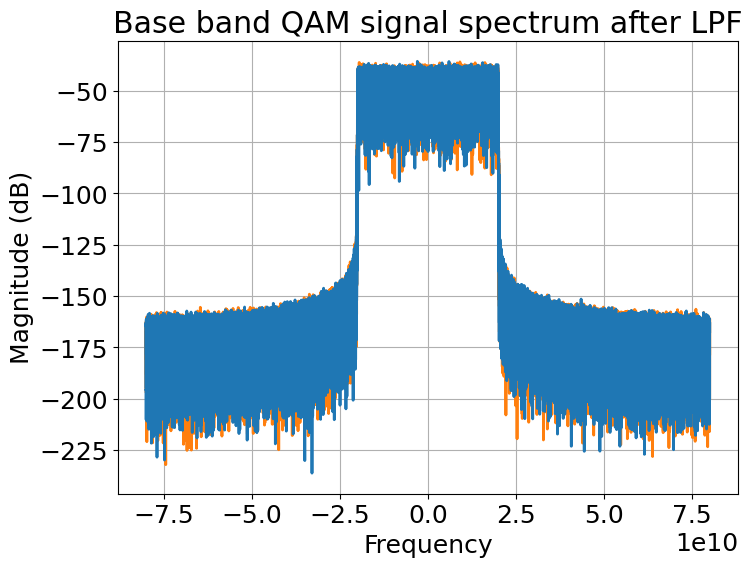

In [5]:
# Plota espectro do sinal QAM em banda base
fig = plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plt.magnitude_spectrum(s[0], Fs=s.fs, scale='dB', color='C1')
plt.magnitude_spectrum(s[1], Fs=s.fs, scale='dB', color='C0')
plt.title('Base band QAM signal spectrum before LPF')
plt.grid(True)

# Filtra ruído fora da banda do sinal (out-of-band noise)
sfilt = normcenter(lowpassFilter(s, Fs, 1/Fb, 0.001, taps=4001))
fig = plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plt.magnitude_spectrum(sfilt[0], Fs=s.fs, scale='dB', color='C1')
plt.magnitude_spectrum(sfilt[1], Fs=s.fs, scale='dB', color='C0')
plt.title('Base band QAM signal spectrum after LPF')
plt.grid(True)

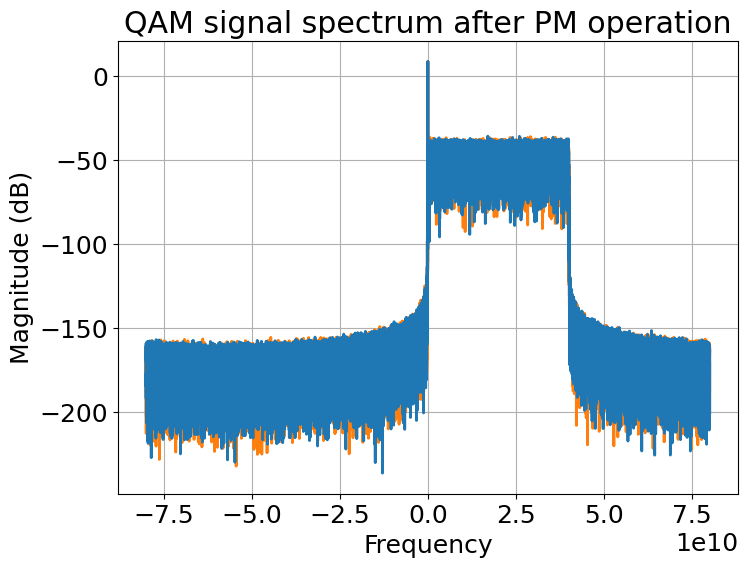

In [6]:
# Gera sinal de fase mínima (sfm(t) = A + s(t)*exp(j*2π*Δf*t))

sfm = sfilt.copy()

t = np.arange(0, s[0].size)*1/s.fs

A = (np.max(np.abs(sfilt)))*np.exp(1j*np.deg2rad(45))
Δf = 2*np.pi*(sfilt.fb/2)*t
sfm = A + sfilt*np.exp(1j*Δf)

plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plt.magnitude_spectrum(sfm[0], Fs=s.fs, scale='dB', color='C1')
plt.magnitude_spectrum(sfm[1], Fs=s.fs, scale='dB', color='C0')
plt.title('QAM signal spectrum after PM operation')
plt.grid(True)

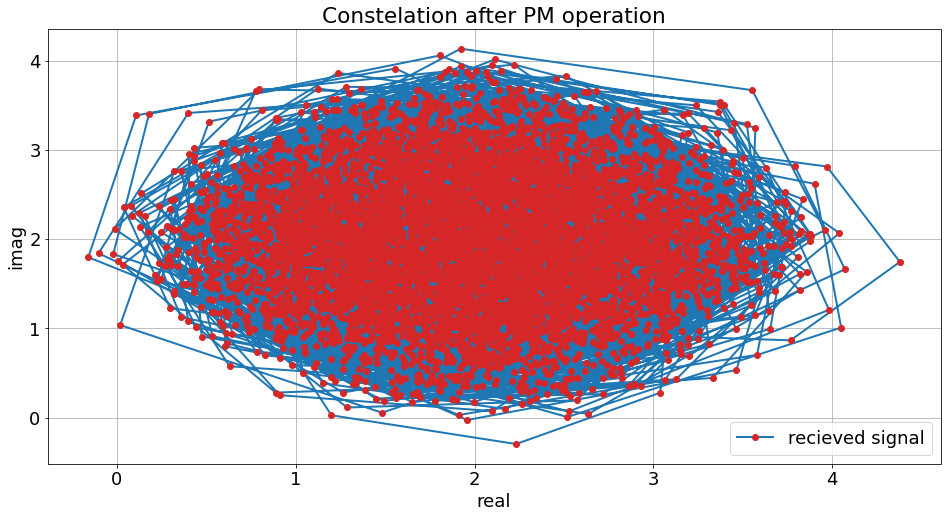

In [7]:
plt.figure(figsize=(16, 8))
plt.plot(sfm[0, :10000].real, sfm[0, :10000].imag, linestyle='-', marker='o',
         markerfacecolor='tab:red',
         markeredgecolor='tab:red')
plt.legend(['recieved signal'], loc='lower right')
plt.xlabel('real')
plt.ylabel('imag')
plt.title('Constelation after PM operation')
plt.grid(True)

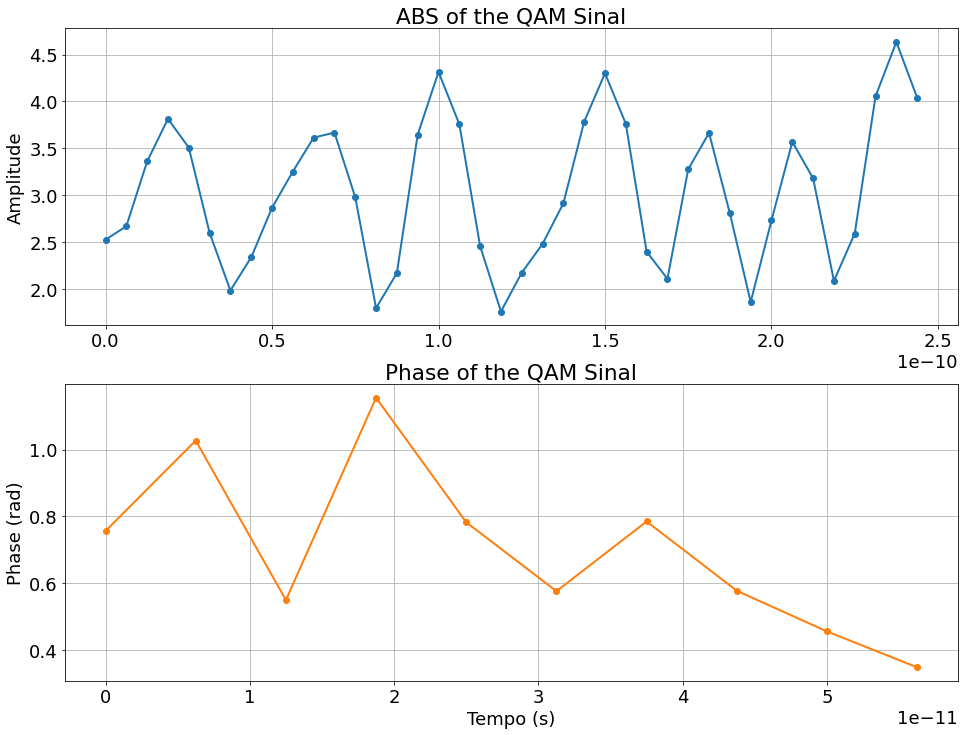

In [8]:
# valor absoluto do sinal -> entrada da rede
amplitudes_train = np.abs(sfm[0])
phases_train = np.angle(sfm[0, ::SpS])  # fase do sinal     -> saída desejada

# valor absoluto do sinal  -> entrada da rede
amplitudes_test = np.abs(sfm[1])
phases_test = np.angle(sfm[1, ::SpS])  # fase do sinal      -> saída desejada

L = 10
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 12))

axes[0].set_title("ABS of the QAM Sinal")
axes[0].plot(t[0:int(4*L)], amplitudes_train[0:int(4*L)], '-o', color='C0')
axes[0].set_ylabel("Amplitude")
axes[0].grid(True)

axes[1].plot(t[0:L], phases_train[0:L], '-o', color='C1')
axes[1].set_title("Phase of the QAM Sinal")
axes[1].set_xlabel("Tempo (s)")
axes[1].set_ylabel("Phase (rad)")
axes[1].grid(True)

In [9]:
X_train = amplitudes_train.reshape(-1, SpS)[:5000]
X_test = amplitudes_test.reshape(-1, SpS)[:5000]

In [10]:
y_train = phases_train.reshape(-1, 1)[:5000]

y_test = phases_test.reshape(-1, 1)[:5000]

In [11]:
print(pd.DataFrame(y_test).describe())

                 0
count  5000.000000
mean      0.784934
std       0.248955
min       0.275483
25%       0.602558
50%       0.785338
75%       0.965120
max       1.290103


<AxesSubplot:ylabel='Count'>

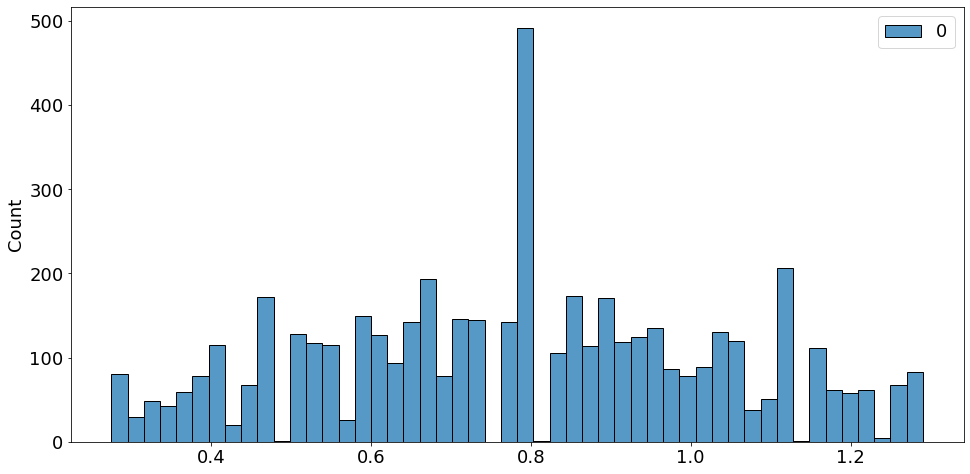

In [12]:
sns.histplot(pd.DataFrame(y_test),bins=50)

<AxesSubplot:>

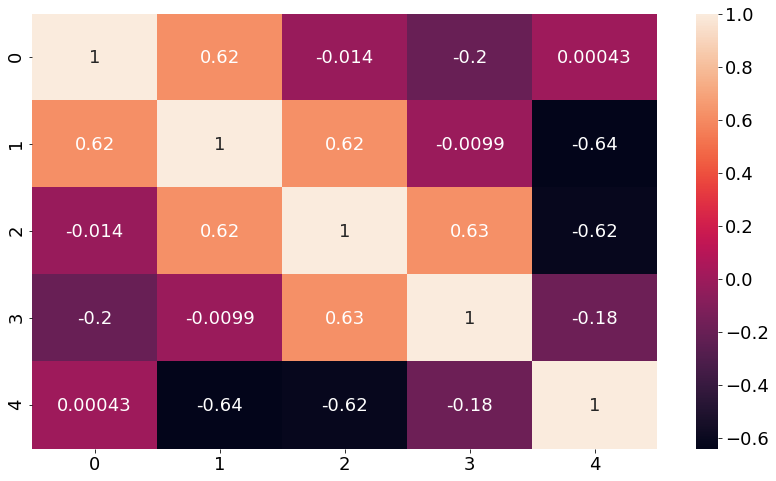

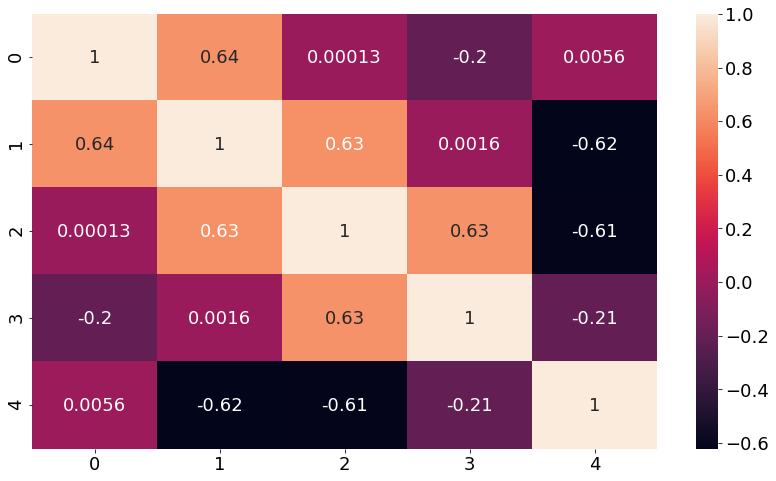

In [13]:
dataset_train = np.concatenate((X_train, y_train), axis=1)
dataset_test = np.concatenate((X_test, y_test), axis=1)

plt.figure(figsize=(14, 8))
sns.heatmap(np.corrcoef(dataset_train.T), annot=True)
plt.figure(figsize=(14, 8))
sns.heatmap(np.corrcoef(dataset_test.T), annot=True)

In [14]:
scaler = MinMaxScaler()
#scaler = StandardScaler()

In [15]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
stop = EarlyStopping(monitor='val_loss',patience=5)

In [17]:
# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(SpS,)))
model.add(Dense(100, activation='relu'))
Dropout(0.2)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               500       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 10,701
Trainable params: 10,701
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(X_train, y_train, epochs=300, callbacks=[stop],
          validation_data=(X_test, y_test), batch_size=64)

Epoch 1/300
79/79 [==============================] - 3s 22ms/step - loss: 0.2330 - val_loss: 0.0415
Epoch 2/300
79/79 [==============================] - 0s 5ms/step - loss: 0.0343 - val_loss: 0.0189
Epoch 3/300
79/79 [==============================] - 0s 5ms/step - loss: 0.0177 - val_loss: 0.0168
Epoch 4/300
79/79 [==============================] - 0s 4ms/step - loss: 0.0162 - val_loss: 0.0158
Epoch 5/300
79/79 [==============================] - 0s 4ms/step - loss: 0.0160 - val_loss: 0.0149
Epoch 6/300
79/79 [==============================] - 0s 4ms/step - loss: 0.0150 - val_loss: 0.0144
Epoch 7/300
79/79 [==============================] - 0s 4ms/step - loss: 0.0148 - val_loss: 0.0138
Epoch 8/300
79/79 [==============================] - 0s 4ms/step - loss: 0.0135 - val_loss: 0.0135
Epoch 9/300
79/79 [==============================] - 0s 4ms/step - loss: 0.0127 - val_loss: 0.0157
Epoch 10/300
79/79 [==============================] - 0s 3ms/step - loss: 0.0139 - val_loss: 0.0134
Epoch 11

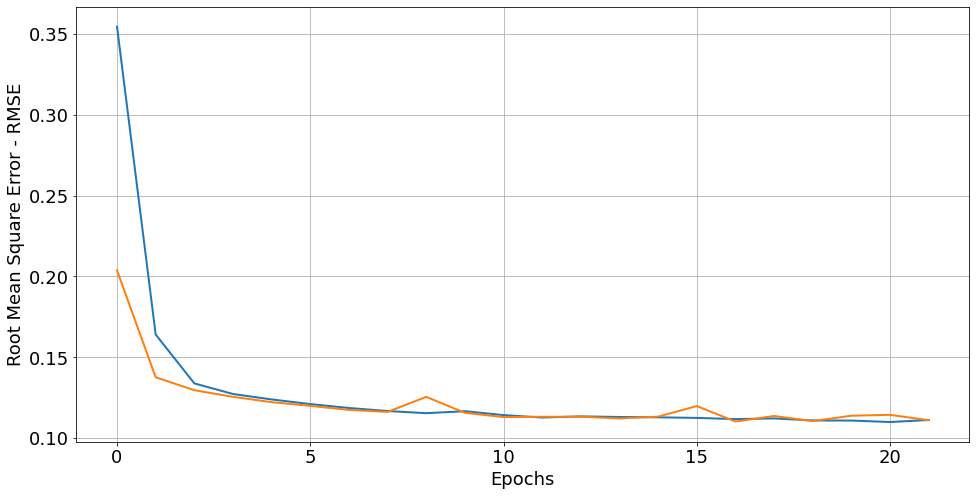

In [20]:
plt.plot(np.sqrt(model.history.history['loss']))
plt.plot(np.sqrt(model.history.history['val_loss']))
plt.xlabel('Epochs')
plt.ylabel('Root Mean Square Error - RMSE')
plt.grid(True)

In [21]:
preds = model.predict(X_test)

In [22]:
test = np.concatenate((preds,y_test),axis=1)
print(test[:5])

[[0.679404 0.688604]
 [0.796835 0.818172]
 [1.133109 0.992833]
 [0.487363 0.426471]
 [0.806654 0.841521]]


In [23]:
print('rmse = ', np.sqrt(mean_squared_error(y_test, preds)))
print('r2 = ', r2_score(y_test, preds))

rmse =  0.11102047072149114
r2 =  0.8010930633294829


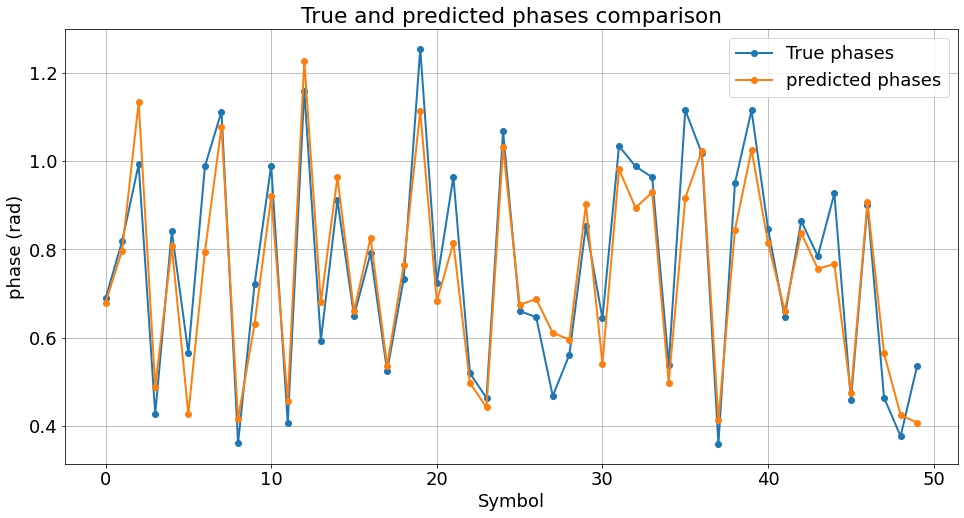

In [24]:
plt.figure(figsize=(16, 8))
plt.plot(y_test[:50], '-o')
plt.plot(preds[:50], '-o')
plt.xlabel('Symbol')
plt.ylabel('phase (rad)')
plt.legend(['True phases', 'predicted phases'])
plt.title('True and predicted phases comparison')
plt.grid(True)
plt.show()